In [1]:
pip install opencv-contrib-python 

Looking in indexes: http://mirrors.aliyun.com/pypi/simple
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install pandas

Looking in indexes: http://mirrors.aliyun.com/pypi/simple
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install seaborn

Looking in indexes: http://mirrors.aliyun.com/pypi/simple
Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install plotly


Looking in indexes: http://mirrors.aliyun.com/pypi/simple
Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install scikit-learn

Looking in indexes: http://mirrors.aliyun.com/pypi/simple
Note: you may need to restart the kernel to use updated packages.


In [6]:
import os
import shutil
import itertools
import pathlib
from PIL import Image

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import seaborn as sns
sns.set_style('whitegrid')
import plotly.express as px

from sklearn.preprocessing import LabelEncoder 
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import MinMaxScaler

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

from tqdm import tqdm  # Import tqdm for progress bar

import warnings
warnings.filterwarnings('ignore')
print('Using PyTorch version', torch.__version__)
# Setup device-agnostic code

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device



Using PyTorch version 2.2.1+cu121


device(type='cuda')

In [7]:
transform= transforms.ToTensor()

In [8]:
metadata = pd.read_csv('ISIC_2019_Training_Metadata.csv')
ground_truth = pd.read_csv('ISIC_2019_Training_GroundTruth.csv')
# Concatenate the two DataFrames based on the 'image' column
df = pd.merge(ground_truth, metadata, on='image').drop('lesion_id', axis=1)
df['target'] = df[['MEL', 'NV', 'BCC', 'AK', 'DF', 'VASC', 'SCC', 'UNK']].sum(axis=1) # 1 for Malignant || 0 for Benign
diagnosis_map = {0: 'benign', 1: 'malignant'}
df['diagnosis'] = df['target'].map(diagnosis_map)
data = df.loc[:, ['image', 'age_approx', 'anatom_site_general', 'sex', 'target', 'diagnosis']]
data['image'] = 'autodl-tmp/ISIC_2019_Training_Input/' + data['image'] + '.jpg'
# data['anatom_site_general'] = data['anatom_site_general'].replace(['lateral torso', 'anterior torso', 'posterior torso'], 'torso')
data

,image,age_approx,anatom_site_general,sex,target,diagnosis
0,autodl-tmp/ISIC_2019_Training_Input/ISIC_00000...,55.0,anterior torso,female,1.0,malignant
1,autodl-tmp/ISIC_2019_Training_Input/ISIC_00000...,30.0,anterior torso,female,1.0,malignant
2,autodl-tmp/ISIC_2019_Training_Input/ISIC_00000...,60.0,upper extremity,female,1.0,malignant
3,autodl-tmp/ISIC_2019_Training_Input/ISIC_00000...,30.0,upper extremity,male,1.0,malignant
4,autodl-tmp/ISIC_2019_Training_Input/ISIC_00000...,80.0,posterior torso,male,1.0,malignant
...,...,...,...,...,...,...
25326,autodl-tmp/ISIC_2019_Training_Input/ISIC_00732...,85.0,head/neck,female,1.0,malignant
25327,autodl-tmp/ISIC_2019_Training_Input/ISIC_00732...,65.0,anterior torso,male,0.0,benign
25328,autodl-tmp/ISIC_2019_Training_Input/ISIC_00732...,70.0,lower extremity,male,1.0,malignant
25329,autodl-tmp/ISIC_2019_Training_Input/ISIC_00732...,55.0,palms/soles,female,1.0,malignant


In [9]:
isic_data = pd.read_csv('train.csv').drop(['patient_id', 'diagnosis'],axis=1)

# Selecting specific columns using .loc[]
isic_Data = isic_data.loc[:, ['image_name', 'age_approx', 'anatom_site_general_challenge', 'sex', 'target', 'benign_malignant']]
isic_data = isic_data.rename(columns={
    'image_name' : 'image',
    'anatom_site_general_challenge': 'anatom_site_general',
    'benign_malignant': 'diagnosis',
})

column_order = ['image', 'age_approx', 'anatom_site_general', 'sex', 'target', 'diagnosis']

isic_data = isic_data[column_order]

# Update the image column with the path to the image
isic_data['image'] = 'autodl-tmp/jpeg/train/' + isic_data['image'] + '.jpg'
isic_data

,image,age_approx,anatom_site_general,sex,target,diagnosis
0,autodl-tmp/jpeg/train/ISIC_2637011.jpg,45.0,head/neck,male,0,benign
1,autodl-tmp/jpeg/train/ISIC_0015719.jpg,45.0,upper extremity,female,0,benign
2,autodl-tmp/jpeg/train/ISIC_0052212.jpg,50.0,lower extremity,female,0,benign
3,autodl-tmp/jpeg/train/ISIC_0068279.jpg,45.0,head/neck,female,0,benign
4,autodl-tmp/jpeg/train/ISIC_0074268.jpg,55.0,upper extremity,female,0,benign
...,...,...,...,...,...,...
33121,autodl-tmp/jpeg/train/ISIC_9999134.jpg,50.0,torso,male,0,benign
33122,autodl-tmp/jpeg/train/ISIC_9999320.jpg,65.0,torso,male,0,benign
33123,autodl-tmp/jpeg/train/ISIC_9999515.jpg,20.0,lower extremity,male,0,benign
33124,autodl-tmp/jpeg/train/ISIC_9999666.jpg,50.0,lower extremity,male,0,benign


In [10]:
# Concatenating the two DataFrames
combined_data = pd.concat([isic_data, data], ignore_index=True).reset_index(drop=True)

combined_data

,image,age_approx,anatom_site_general,sex,target,diagnosis
0,autodl-tmp/jpeg/train/ISIC_2637011.jpg,45.0,head/neck,male,0.0,benign
1,autodl-tmp/jpeg/train/ISIC_0015719.jpg,45.0,upper extremity,female,0.0,benign
2,autodl-tmp/jpeg/train/ISIC_0052212.jpg,50.0,lower extremity,female,0.0,benign
3,autodl-tmp/jpeg/train/ISIC_0068279.jpg,45.0,head/neck,female,0.0,benign
4,autodl-tmp/jpeg/train/ISIC_0074268.jpg,55.0,upper extremity,female,0.0,benign
...,...,...,...,...,...,...
58452,autodl-tmp/ISIC_2019_Training_Input/ISIC_00732...,85.0,head/neck,female,1.0,malignant
58453,autodl-tmp/ISIC_2019_Training_Input/ISIC_00732...,65.0,anterior torso,male,0.0,benign
58454,autodl-tmp/ISIC_2019_Training_Input/ISIC_00732...,70.0,lower extremity,male,1.0,malignant
58455,autodl-tmp/ISIC_2019_Training_Input/ISIC_00732...,55.0,palms/soles,female,1.0,malignant


,Feature Name,Number of Nulls
0,image,0
1,age_approx,505
2,anatom_site_general,3158
3,sex,449
4,target,0
5,diagnosis,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58457 entries, 0 to 58456
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   image                58457 non-null  object 
 1   age_approx           57952 non-null  float64
 2   anatom_site_general  55299 non-null  object 
 3   sex                  58008 non-null  object 
 4   target               58457 non-null  float64
 5   diagnosis            58457 non-null  object 
dtypes: float64(2), object(4)
memory usage: 2.7+ MB
None


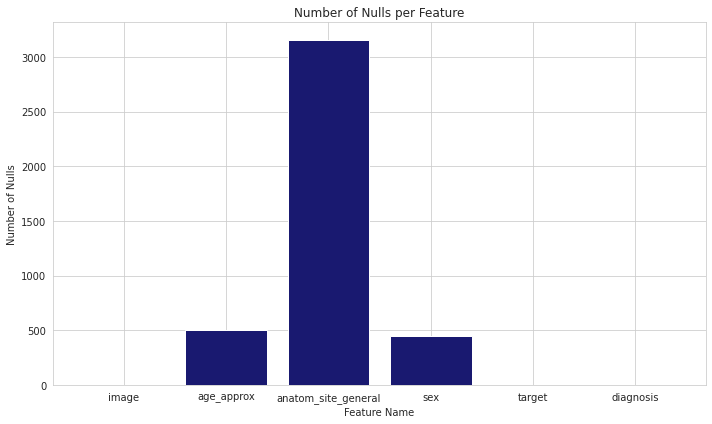

,Feature Name,Number of Nulls
0,image,0
1,age_approx,0
2,anatom_site_general,0
3,sex,0
4,target,0
5,diagnosis,0


<class 'pandas.core.frame.DataFrame'>
Index: 55011 entries, 0 to 58456
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   image                55011 non-null  object 
 1   age_approx           55011 non-null  float64
 2   anatom_site_general  55011 non-null  object 
 3   sex                  55011 non-null  object 
 4   target               55011 non-null  float64
 5   diagnosis            55011 non-null  object 
dtypes: float64(2), object(4)
memory usage: 2.9+ MB
None


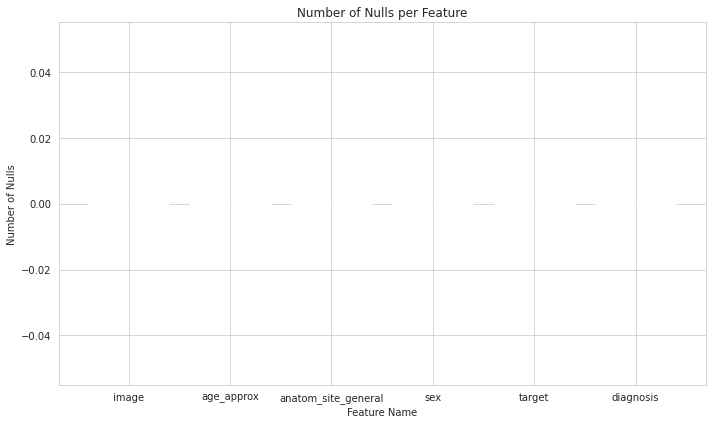

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
def null_analysis(data):
    df_null_info = pd.DataFrame(columns=['Feature Name', 'Number of Nulls'])
    for data_label in data.columns.tolist():
        num_nulls = data[data_label].isnull().sum()
        df_null_info = pd.concat([df_null_info, pd.DataFrame({'Feature Name': [data_label], 'Number of Nulls': [num_nulls]})], ignore_index=True)
    display(df_null_info)
    print(data.info())

    plt.figure(figsize=(10, 6))
    plt.bar(df_null_info['Feature Name'], df_null_info['Number of Nulls'], color='midnightblue')
    plt.xlabel('Feature Name')
    plt.ylabel('Number of Nulls')
    plt.title('Number of Nulls per Feature')

    # Show the plot
    plt.tight_layout()
    plt.show()

null_analysis(combined_data)
combined_data = combined_data.dropna()
null_analysis(combined_data)

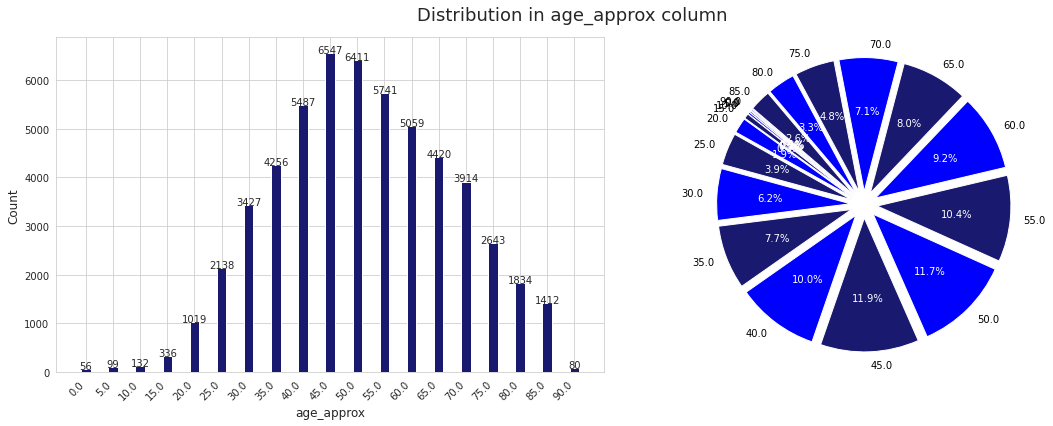

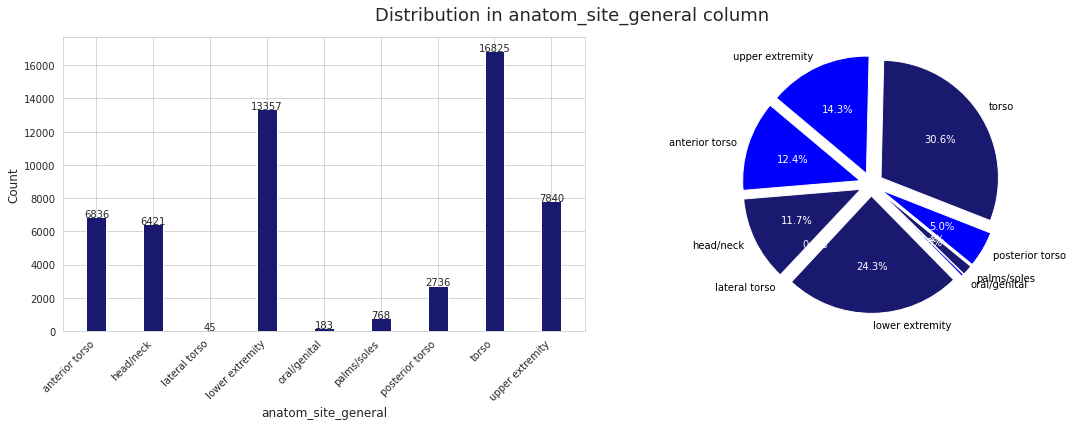

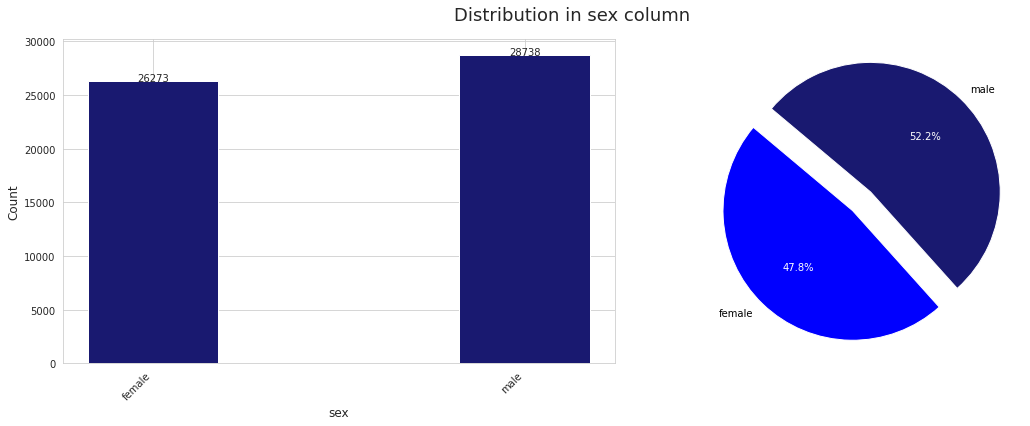

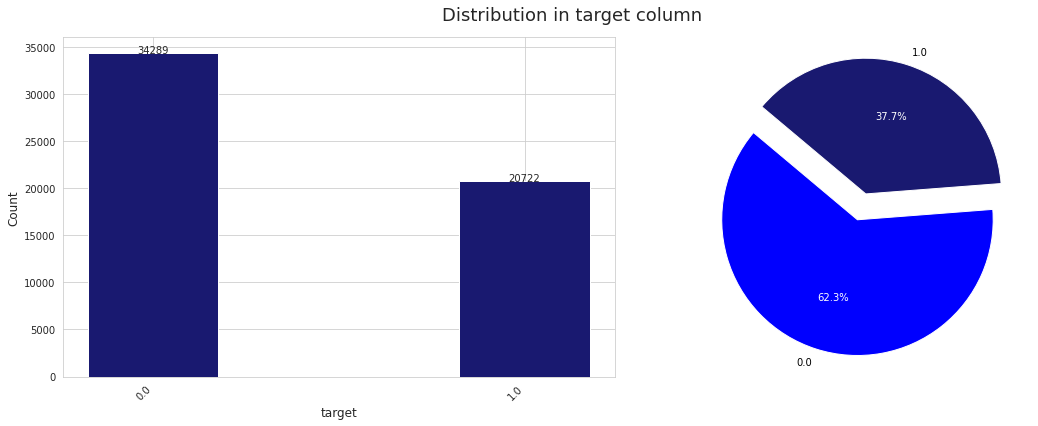

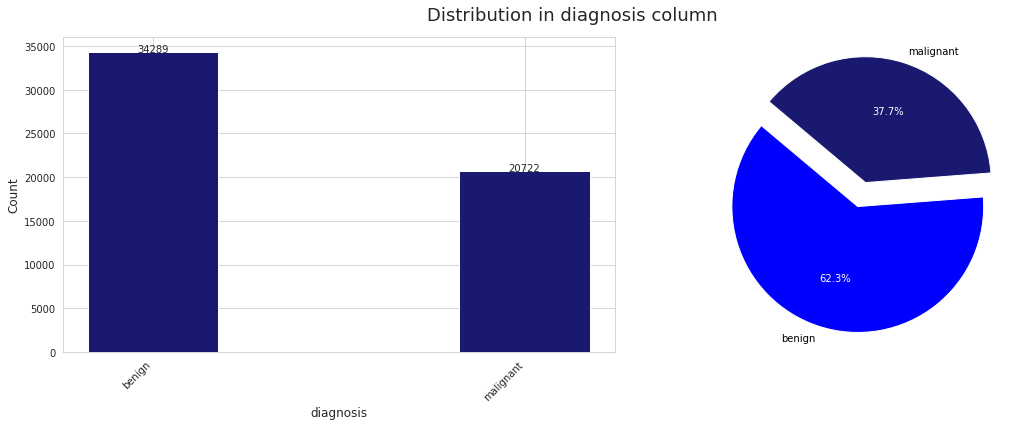

In [12]:
def plot_distribution(dataframe, target_column):
    # Calculate value counts and sort them
    value_counts = dataframe[target_column].value_counts().sort_index()

    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # Bar plot on the first subplot
    bar_width = 0.35
    ind = np.arange(len(value_counts))
    rects = ax1.bar(ind, value_counts.values, width=bar_width, color='midnightblue')
    ax1.set_xlabel(target_column, fontsize=12)
    ax1.set_ylabel('Count', fontsize=12)
    ax1.set_xticks(ind)
    ax1.set_xticklabels(value_counts.index, rotation=45, ha='right', fontsize=10)

    # Add values on top of bars
    for index, value in enumerate(value_counts.values):
        ax1.text(index, value + 0.1, str(value), ha='center', fontsize=10)

    # Pie plot 
    explode = [0.1 for i in range(len(value_counts))]
    patches, texts, autotexts = ax2.pie(value_counts, labels=value_counts.index, autopct='%1.1f%%', colors=["blue","midnightblue"], explode=explode, startangle=140)

    # Adjust the distance of the labels from the center
    for text in texts:
        text.set_color('black')
        text.set_fontsize(10)
    for autotext in autotexts:
        autotext.set_fontsize(10)
        autotext.set_color('white')
    # Main title for the figure
    fig.suptitle(f'Distribution in {target_column} column', fontsize=18)
    
    # Adjust layout and display the figure
    plt.tight_layout()
    plt.show()
    
for column in data.columns:
    if column == 'image':
        continue
    plot_distribution(combined_data, column)

In [13]:
labelencoder= LabelEncoder() 
combined_data['anatom_site_general_encoded'] = labelencoder.fit_transform(combined_data['anatom_site_general']) 
combined_data['sex_encoded'] = labelencoder.fit_transform(combined_data['sex']) 
combined_data['diagnosis_encoded'] = labelencoder.fit_transform(combined_data['diagnosis'])
combined_data_NoC=combined_data.drop(['anatom_site_general', 'sex', 'diagnosis'], axis=1)
# scale the age
scaler = MinMaxScaler()
combined_data_NoC['age_approx'] = scaler.fit_transform( combined_data_NoC['age_approx'].values.reshape(-1, 1))

combined_data_NoC.head()

,image,age_approx,target,anatom_site_general_encoded,sex_encoded,diagnosis_encoded
0,autodl-tmp/jpeg/train/ISIC_2637011.jpg,0.500000,0.0,1,1,0
1,autodl-tmp/jpeg/train/ISIC_0015719.jpg,0.500000,0.0,8,0,0
2,autodl-tmp/jpeg/train/ISIC_0052212.jpg,0.555556,0.0,3,0,0
3,autodl-tmp/jpeg/train/ISIC_0068279.jpg,0.500000,0.0,1,0,0
4,autodl-tmp/jpeg/train/ISIC_0074268.jpg,0.611111,0.0,8,0,0


In [14]:
train_data, test_data = train_test_split(combined_data_NoC, test_size=0.3, stratify=combined_data_NoC['target'], random_state=42)
valid_data, test_data = train_test_split(test_data, test_size=0.5, stratify=test_data['target'], random_state=42)

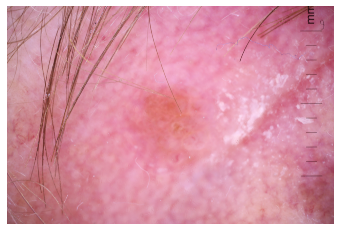

,image,age_approx,target,anatom_site_general_encoded,sex_encoded,diagnosis_encoded
34258,autodl-tmp/ISIC_2019_Training_Input/ISIC_00111...,0.666667,1.0,3,0,1
10846,autodl-tmp/jpeg/train/ISIC_3349562.jpg,0.222222,0.0,3,1,0
51270,autodl-tmp/ISIC_2019_Training_Input/ISIC_00618...,0.833333,0.0,0,0,0
46910,autodl-tmp/ISIC_2019_Training_Input/ISIC_00548...,0.833333,1.0,0,1,1
38073,autodl-tmp/ISIC_2019_Training_Input/ISIC_00263...,0.333333,1.0,6,0,1
...,...,...,...,...,...,...
37494,autodl-tmp/ISIC_2019_Training_Input/ISIC_00257...,0.388889,1.0,3,0,1
1602,autodl-tmp/jpeg/train/ISIC_0584566.jpg,0.444444,0.0,8,1,0
803,autodl-tmp/jpeg/train/ISIC_0343957.jpg,0.444444,0.0,8,0,0
29621,autodl-tmp/jpeg/train/ISIC_8961663.jpg,0.944444,0.0,7,0,0


In [15]:
from PIL import Image
import matplotlib.pyplot as plt

# Define the file path of the image you want to display
image_path = 'autodl-tmp/jpeg/train/ISIC_2637011.jpg'

# Open the image using PI
image = Image.open(image_path)

# Display the image using matplotlib
plt.figure()
plt.imshow(image)
plt.axis('off')  # Turn off the axis
plt.show()

train_data

In [16]:
class CustomDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = self.dataframe.iloc[idx, 0]
        image = Image.open(img_name)

        age = torch.tensor(self.dataframe.iloc[idx, 1], dtype=torch.float32).to(device)
        anatom_site = torch.tensor(self.dataframe.iloc[idx, 3], dtype=torch.float32).to(device)
        sex = torch.tensor(self.dataframe.iloc[idx, 4], dtype=torch.float32).to(device)
        label = torch.tensor(self.dataframe.iloc[idx, 5], dtype=torch.long).to(device)

        if self.transform:
            image = self.transform(image)

        return image.to(device), age, anatom_site, sex, label

In [17]:

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=30),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=3)], p=0.5),
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=5)], p=0.5),
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=7)], p=0.5),
    transforms.RandomApply([transforms.RandomAffine(degrees=30, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=10)], p=0.5),
    transforms.RandomApply([transforms.RandomPerspective(distortion_scale=0.5)], p=0.5),
    transforms.ToTensor(),  
])

# Define transforms for the data (adjust as necessary)
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(), 
])

# Define dataset and dataloaders for train and test sets
train_dataset = CustomDataset(train_data, transform=train_transform)

valid_dataset = CustomDataset(valid_data, transform=test_transform)
test_dataset = CustomDataset(test_data, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True,drop_last=True)

valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, drop_last=True)

print('Data loading and preprocessing completed.')


Data loading and preprocessing completed.


In [18]:
# Get one batch
for batch in train_loader:
    images, ages, anatom_sites, sexs, labels = batch
    break



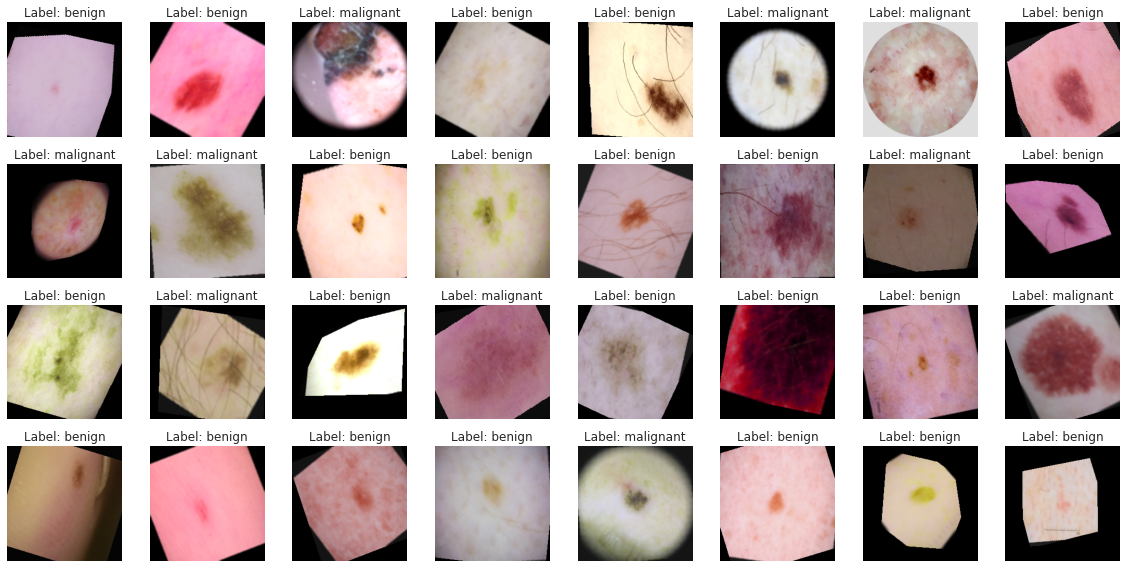

In [19]:
# Create a figure and a grid of subplots
fig, axs = plt.subplots(4, 8, figsize=(16, 8))

# Flatten the axs array so that we can iterate over subplots easily
axs = axs.flatten()

# Plot each image
for i, ax in enumerate(axs):
    ax.imshow(images[i].permute(1, 2, 0).cpu().numpy())  # Convert tensor to numpy array and permute dimensions
    ax.axis('off')  # Turn off axis
    ax.set_title(f'Label: {diagnosis_map[int(labels[i])]}')  # Set title for each subplot

plt.tight_layout()  # Adjust layout to make subplots fit
plt.show()

In [20]:
resnet18 = torchvision.models.resnet18(pretrained=True).to(device)

print(resnet18)
for batch in train_loader:
    images, ages, anatom_sites, sexs, labels = [item.to(device) for item in batch]
    break

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [21]:
resnet18.fc = torch.nn.Linear(in_features=512, out_features=2)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet18.parameters(), lr=3e-5)
resnet18 = resnet18.to(device)

In [22]:
display(train_loader)
# Training the model
model = resnet18
criterion = nn.CrossEntropyLoss()

def validate_model(model, val_loader, criterion, device):  
    model.eval()  # 设置为评估模式  
    val_loss = 0.0  
    correct = 0  
    total = 0  
    with torch.no_grad():  # 不需要计算梯度  
        for data in tqdm(val_loader, desc="Validation"):  
            inputs, ages, anatom_sites, sexs, labels = [item.to(device) for item in data]  
            outputs = model(inputs)  
            loss = criterion(outputs, labels)  
            val_loss += loss.item()  
            _, predicted = torch.max(outputs, 1)  
            total += labels.size(0)  
            correct += (predicted == labels).sum().item()  
    val_loss /= len(val_loader)  
    val_accuracy = correct / total  
    print(f"Validation Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.2%}")  
    return val_loss, val_accuracy  
  
# 测试函数  
def test_model(model, test_loader, criterion, device):  
    model.eval()  # 设置为评估模式  
    test_loss = 0.0  
    correct = 0  
    total = 0  
    with torch.no_grad():  # 不需要计算梯度  
        for data in tqdm(test_loader, desc="Testing"):  
            inputs, ages, anatom_sites, sexs, labels = [item.to(device) for item in data]  
            outputs = model(inputs)  
            loss = criterion(outputs, labels)  
            test_loss += loss.item()  
            _, predicted = torch.max(outputs, 1)  
            total += labels.size(0)  
            correct += (predicted == labels).sum().item()  
    test_loss /= len(test_loader)  
    test_accuracy = correct / total  
    print(f"Test Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.2%}")  
    return test_loss, test_accuracy 
epochs = 2
for epoch in range(epochs):
    model.train()
    correct = 0
    total = 0
    running_loss = 0.0
    
    for data in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
        inputs, ages, anatom_sites, sexs, labels = [item.to(device) for item in data]
        
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = correct / total
    
    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2%}")
    val_loss, val_acc = validate_model(model, valid_loader, criterion, device)  
  
    # 在验证完成后进行测试  
    test_loss, test_acc = test_model(model, test_loader, criterion, device)  

print("Training, Validation, and Testing complete!")

Epoch 1/2: 100%|██████████| 1203/1203 [48:58<00:00,  2.44s/it]


Epoch 1/2, Loss: 0.3298, Accuracy: 86.03%


Validation: 100%|██████████| 258/258 [10:19<00:00,  2.40s/it]


Validation Loss: 0.2310, Accuracy: 91.38%


Testing: 100%|██████████| 257/257 [11:03<00:00,  2.58s/it]


Test Loss: 0.2362, Accuracy: 90.94%


Epoch 2/2: 100%|██████████| 1203/1203 [58:36<00:00,  2.92s/it] 


Epoch 2/2, Loss: 0.2645, Accuracy: 89.74%


Validation: 100%|██████████| 258/258 [09:22<00:00,  2.18s/it]


Validation Loss: 0.2079, Accuracy: 92.46%


Testing: 100%|██████████| 257/257 [09:30<00:00,  2.22s/it]

Test Loss: 0.2220, Accuracy: 91.68%
Training, Validation, and Testing complete!


In [38]:
torch.save(model.state_dict(), 'resnet_model.pth')


In [24]:
'''
import torch  
import torch.nn as nn  
from torchvision import models  
  
# 假设您已经有一个加载了权重的resnet18模型  
model = models.resnet18(pretrained=False)  # 实例化模型  
num_ftrs = model.fc.in_features  # 获取全连接层的输入特征数  
# 假设您的任务有10个类别（您需要根据实际情况设置num_classes）  
model.fc = nn.Linear(num_ftrs, 4)  # 替换全连接层以适应您的分类任务  
model.load_state_dict(torch.load('resnet_model.pth'))  # 加载您自己的权重文件  
model.eval()  # 设置模型为评估模式  
  
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  
model.to(device)  
  
# 初始化准确率计数器  
correct = 0  
total = 0  
  
# 不需要计算梯度  
with torch.no_grad():  
    for images, _ in test_loader:  
        images = images.to(device)  
        outputs = model(images)  # 获取模型输出  
        _, predicted = torch.max(outputs, 1)  # 获取预测类别  
        total += images.size(0)  # 累加样本总数  
        correct += (predicted == labels).sum().item() if labels is not None else 0  # 累加预测正确的样本数（这里labels为None，因为测试集没有标签）  
  
# 计算准确率  
accuracy = 100 * correct / total  
print(f'模型在测试集上的准确率: {accuracy:.2f}%')
'''

"\nimport torch  \nimport torch.nn as nn  \nfrom torchvision import models  \n  \n# 假设您已经有一个加载了权重的resnet18模型  \nmodel = models.resnet18(pretrained=False)  # 实例化模型  \nnum_ftrs = model.fc.in_features  # 获取全连接层的输入特征数  \n# 假设您的任务有10个类别（您需要根据实际情况设置num_classes）  \nmodel.fc = nn.Linear(num_ftrs, 4)  # 替换全连接层以适应您的分类任务  \nmodel.load_state_dict(torch.load('resnet_model.pth'))  # 加载您自己的权重文件  \nmodel.eval()  # 设置模型为评估模式  \n  \ndevice = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  \nmodel.to(device)  \n  \n# 初始化准确率计数器  \ncorrect = 0  \ntotal = 0  \n  \n# 不需要计算梯度  \nwith torch.no_grad():  \n    for images, _ in test_loader:  \n        images = images.to(device)  \n        outputs = model(images)  # 获取模型输出  \n        _, predicted = torch.max(outputs, 1)  # 获取预测类别  \n        total += images.size(0)  # 累加样本总数  \n        correct += (predicted == labels).sum().item() if labels is not None else 0  # 累加预测正确的样本数（这里labels为None，因为测试集没有标签）  \n  \n# 计算准确率  \naccuracy = 100 * correct / total  \n

In [25]:
'''
import torch  
from torch.utils.data import DataLoader  
from your_dataset_module import CustomDataset  # 确保这个模块包含CustomDataset类  
from your_model_module import ResNetModel  # 假设ResNetModel类定义在这个模块中  
  
# 加载测试集数据  
test_dataset = CustomDataset(test_data, transform=test_transform)  
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)  
  
# 加载模型  
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  
model = ResNetModel()  # 使用您的ResNet模型类  
model.load_state_dict(torch.load('resnet_model.pth', map_location=device))  # 加载模型权重  
model.to(device)  
model.eval()  # 设置模型为评估模式  
  
# 初始化准确率计数器  
correct = 0  
total = 0  
  
# 不需要计算梯度  
with torch.no_grad():  
    for images, labels in test_loader:  
        images, labels = images.to(device), labels.to(device)  
        outputs = model(images)  # 获取模型输出  
        _, predicted = torch.max(outputs, 1)  # 获取预测类别  
        total += labels.size(0)  # 累加样本总数  
        correct += (predicted == labels).sum().item()  # 累加预测正确的样本数  
  
# 计算准确率  
accuracy = 100 * correct / total  
print(f'模型在测试集上的准确率: {accuracy:.2f}%')
'''

"\nimport torch  \nfrom torch.utils.data import DataLoader  \nfrom your_dataset_module import CustomDataset  # 确保这个模块包含CustomDataset类  \nfrom your_model_module import ResNetModel  # 假设ResNetModel类定义在这个模块中  \n  \n# 加载测试集数据  \ntest_dataset = CustomDataset(test_data, transform=test_transform)  \ntest_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)  \n  \n# 加载模型  \ndevice = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  \nmodel = ResNetModel()  # 使用您的ResNet模型类  \nmodel.load_state_dict(torch.load('resnet_model.pth', map_location=device))  # 加载模型权重  \nmodel.to(device)  \nmodel.eval()  # 设置模型为评估模式  \n  \n# 初始化准确率计数器  \ncorrect = 0  \ntotal = 0  \n  \n# 不需要计算梯度  \nwith torch.no_grad():  \n    for images, labels in test_loader:  \n        images, labels = images.to(device), labels.to(device)  \n        outputs = model(images)  # 获取模型输出  \n        _, predicted = torch.max(outputs, 1)  # 获取预测类别  \n        total += labels.size(0)  # 累加样本总数  \n        correct += (pred

In [26]:
###VGG###

In [27]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms, models
# Load pre-trained VGG model
model = models.vgg16(pretrained=True)
model.classifier[6] = nn.Linear(4096, 2)  # Modify the last fully connected layer for your desired number of classes
model = model.to(device)

In [28]:
# Training the model
model = model
criterion = nn.CrossEntropyLoss()
def validate_model(model, val_loader, criterion, device):  
    model.eval()  # 设置为评估模式  
    val_loss = 0.0  
    correct = 0  
    total = 0  
    with torch.no_grad():  # 不需要计算梯度  
        for data in tqdm(val_loader, desc="Validation"):  
            inputs, ages, anatom_sites, sexs, labels = [item.to(device) for item in data]  
            outputs = model(inputs)  
            loss = criterion(outputs, labels)  
            val_loss += loss.item()  
            _, predicted = torch.max(outputs, 1)  
            total += labels.size(0)  
            correct += (predicted == labels).sum().item()  
    val_loss /= len(val_loader)  
    val_accuracy = correct / total  
    print(f"Validation Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.2%}")  
    return val_loss, val_accuracy  
  
# 测试函数  
def test_model(model, test_loader, criterion, device):  
    model.eval()  # 设置为评估模式  
    test_loss = 0.0  
    correct = 0  
    total = 0  
    with torch.no_grad():  # 不需要计算梯度  
        for data in tqdm(test_loader, desc="Testing"):  
            inputs, ages, anatom_sites, sexs, labels = [item.to(device) for item in data]  
            outputs = model(inputs)  
            loss = criterion(outputs, labels)  
            test_loss += loss.item()  
            _, predicted = torch.max(outputs, 1)  
            total += labels.size(0)  
            correct += (predicted == labels).sum().item()  
    test_loss /= len(test_loader)  
    test_accuracy = correct / total  
    print(f"Test Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.2%}")  
    return test_loss, test_accuracy 
epochs = 2
for epoch in range(epochs):
    model.train()
    correct = 0
    total = 0
    running_loss = 0.0
    
    for data in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
        inputs, ages, anatom_sites, sexs, labels = [item.to(device) for item in data]
        
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = correct / total
    
    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2%}")
    val_loss, val_acc = validate_model(model, valid_loader, criterion, device)  
  
    # 在验证完成后进行测试  
    test_loss, test_acc = test_model(model, test_loader, criterion, device)  

print("Training, Validation, and Testing complete!")


Epoch 1/2: 100%|██████████| 1203/1203 [53:43<00:00,  2.68s/it]


Epoch 1/2, Loss: 0.6878, Accuracy: 59.22%


Validation: 100%|██████████| 258/258 [08:40<00:00,  2.02s/it]


Validation Loss: 0.6542, Accuracy: 63.20%


Testing: 100%|██████████| 257/257 [08:53<00:00,  2.08s/it]


Test Loss: 0.6510, Accuracy: 63.78%


Epoch 2/2: 100%|██████████| 1203/1203 [47:54<00:00,  2.39s/it]


Epoch 2/2, Loss: 0.6853, Accuracy: 59.68%


Validation: 100%|██████████| 258/258 [08:39<00:00,  2.01s/it]


Validation Loss: 0.6542, Accuracy: 63.20%


Testing: 100%|██████████| 257/257 [08:42<00:00,  2.03s/it]

Test Loss: 0.6510, Accuracy: 63.78%
Training, Validation, and Testing complete!


In [29]:
torch.save(model.state_dict(), 'VGG_model.pth')

In [30]:
###Densenet###

In [31]:
# Load the pre-trained DenseNet model
densenet = torchvision.models.densenet121(pretrained=True).to(device)

# Modify the fully connected layer for classification
densenet.classifier = nn.Linear(in_features=1024, out_features=2)

# Define the loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(densenet.parameters(), lr=3e-5)

# Move the model to the device
densenet = densenet.to(device)

In [32]:
def validate_model(model, val_loader, criterion, device):  
    model.eval()  # 设置为评估模式  
    val_loss = 0.0  
    correct = 0  
    total = 0  
    with torch.no_grad():  # 不需要计算梯度  
        for data in tqdm(val_loader, desc="Validation"):  
            inputs, ages, anatom_sites, sexs, labels = [item.to(device) for item in data]  
            outputs = model(inputs)  
            loss = criterion(outputs, labels)  
            val_loss += loss.item()  
            _, predicted = torch.max(outputs, 1)  
            total += labels.size(0)  
            correct += (predicted == labels).sum().item()  
    val_loss /= len(val_loader)  
    val_accuracy = correct / total  
    print(f"Validation Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.2%}")  
    return val_loss, val_accuracy  
  
# 测试函数  
def test_model(model, test_loader, criterion, device):  
    model.eval()  # 设置为评估模式  
    test_loss = 0.0  
    correct = 0  
    total = 0  
    with torch.no_grad():  # 不需要计算梯度  
        for data in tqdm(test_loader, desc="Testing"):  
            inputs, ages, anatom_sites, sexs, labels = [item.to(device) for item in data]  
            outputs = model(inputs)  
            loss = criterion(outputs, labels)  
            test_loss += loss.item()  
            _, predicted = torch.max(outputs, 1)  
            total += labels.size(0)  
            correct += (predicted == labels).sum().item()  
    test_loss /= len(test_loader)  
    test_accuracy = correct / total  
    print(f"Test Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.2%}")  
    return test_loss, test_accuracy 


# Training the model
model = densenet

epochs = 2

for epoch in range(epochs):
    model.train()
    correct = 0
    total = 0
    running_loss = 0.0

    for data in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
        inputs, ages, anatom_sites, sexs, labels = [item.to(device) for item in data]

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = loss_fn(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = correct / total

    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2%}")
    val_loss, val_acc = validate_model(model, valid_loader, criterion, device)  
  
    # 在验证完成后进行测试  
    test_loss, test_acc = test_model(model, test_loader, criterion, device)  

print("Training, Validation, and Testing complete!")


Epoch 1/2: 100%|██████████| 1203/1203 [46:19<00:00,  2.31s/it]


Epoch 1/2, Loss: 0.3253, Accuracy: 86.36%


Validation: 100%|██████████| 258/258 [08:49<00:00,  2.05s/it]


Validation Loss: 0.2176, Accuracy: 92.45%


Testing: 100%|██████████| 257/257 [08:59<00:00,  2.10s/it]


Test Loss: 0.2156, Accuracy: 91.93%


Epoch 2/2: 100%|██████████| 1203/1203 [46:34<00:00,  2.32s/it]


Epoch 2/2, Loss: 0.2463, Accuracy: 90.41%


Validation: 100%|██████████| 258/258 [08:37<00:00,  2.01s/it]


Validation Loss: 0.2171, Accuracy: 92.61%


Testing: 100%|██████████| 257/257 [08:46<00:00,  2.05s/it]

Test Loss: 0.2179, Accuracy: 91.97%
Training, Validation, and Testing complete!


In [33]:
torch.save(model.state_dict(), 'Densenet_model.pth')

In [34]:
###Inception###

In [35]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.models import inception_v3

# Load the Inception model
model = inception_v3(pretrained=True).to(device)
# print(model)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
model = model.to(device)

# support another imput sizing
train_transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=30),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=3)], p=0.5),
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=5)], p=0.5),
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=7)], p=0.5),
    transforms.RandomApply([transforms.RandomAffine(degrees=30, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=10)], p=0.5),
    transforms.RandomApply([transforms.RandomPerspective(distortion_scale=0.5)], p=0.5),
    transforms.ToTensor(),  
])

# Define transforms for the data (adjust as necessary)
test_transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(), 
])

# Define dataset and dataloaders for train and test sets
train_dataset = CustomDataset(train_data, transform=train_transform)
valid_dataset = CustomDataset(valid_data, transform=test_transform)
test_dataset = CustomDataset(test_data, transform=test_transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True,drop_last=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, drop_last=True)
print('Data loading and preprocessing completed.')


Data loading and preprocessing completed.


In [36]:


def validate_model(model, val_loader, criterion, device):  
    model.eval()  # 设置为评估模式  
    val_loss = 0.0  
    correct = 0  
    total = 0  
    with torch.no_grad():  # 不需要计算梯度  
        for data in tqdm(val_loader, desc="Validation"):  
            inputs, ages, anatom_sites, sexs, labels = [item.to(device) for item in data]  
            outputs = model(inputs)  
            loss = criterion(outputs, labels)  
            val_loss += loss.item()  
            _, predicted = torch.max(outputs, 1)  
            total += labels.size(0)  
            correct += (predicted == labels).sum().item()  
    val_loss /= len(val_loader)  
    val_accuracy = correct / total  
    print(f"Validation Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.2%}")  
    return val_loss, val_accuracy  
  
# 测试函数  
def test_model(model, test_loader, criterion, device):  
    model.eval()  # 设置为评估模式  
    test_loss = 0.0  
    correct = 0  
    total = 0  
    with torch.no_grad():  # 不需要计算梯度  
        for data in tqdm(test_loader, desc="Testing"):  
            inputs, ages, anatom_sites, sexs, labels = [item.to(device) for item in data]  
            outputs = model(inputs)  
            loss = criterion(outputs, labels)  
            test_loss += loss.item()  
            _, predicted = torch.max(outputs, 1)  
            total += labels.size(0)  
            correct += (predicted == labels).sum().item()  
    test_loss /= len(test_loader)  
    test_accuracy = correct / total  
    print(f"Test Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.2%}")  
    return test_loss, test_accuracy 
display(valid_loader)
display(test_loader)
# Training the model
model = model
criterion = nn.CrossEntropyLoss()
epochs = 2
for epoch in range(epochs):
    model.train()
    correct = 0
    total = 0
    running_loss = 0.0
    
    for data in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
        inputs, ages, anatom_sites, sexs, labels = [item.to(device) for item in data]
        
        optimizer.zero_grad()
        
        outputs = model(inputs)
        main_output = outputs[0]  
        loss = criterion(main_output, labels)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        _, predicted = torch.max(outputs[0], 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = correct / total
    
    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2%}")
    val_loss, val_acc = validate_model(model, valid_loader, criterion, device)  
  
    # 在验证完成后进行测试  
    test_loss, test_acc = test_model(model, test_loader, criterion, device)  

print("Training, Validation, and Testing complete!")

Epoch 1/2: 100%|██████████| 1203/1203 [49:02<00:00,  2.45s/it]


Epoch 1/2, Loss: 0.4144, Accuracy: 84.17%


Validation: 100%|██████████| 258/258 [08:37<00:00,  2.01s/it]


Validation Loss: 0.2386, Accuracy: 90.72%


Testing: 100%|██████████| 257/257 [08:37<00:00,  2.01s/it]


Test Loss: 0.2556, Accuracy: 89.90%


Epoch 2/2: 100%|██████████| 1203/1203 [48:33<00:00,  2.42s/it]


Epoch 2/2, Loss: 0.2711, Accuracy: 89.26%


Validation: 100%|██████████| 258/258 [08:31<00:00,  1.98s/it]


Validation Loss: 0.2006, Accuracy: 92.60%


Testing: 100%|██████████| 257/257 [08:39<00:00,  2.02s/it]

Test Loss: 0.2121, Accuracy: 91.93%
Training, Validation, and Testing complete!


In [37]:
torch.save(model.state_dict(), 'inception_model.pth')